img meta: 
 shape:(17, 64, 64) 
 spacing:(6.6437, 6.643699, 6.643699)
img meta: 
 shape:(136, 64, 64) 
 spacing:(6.6437, 6.643699, 6.643699)
img meta: 
 shape:(9, 20, 340) 
 spacing:(6.6437, 6.643699, 6.643699)


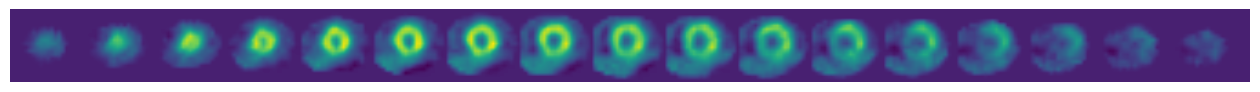

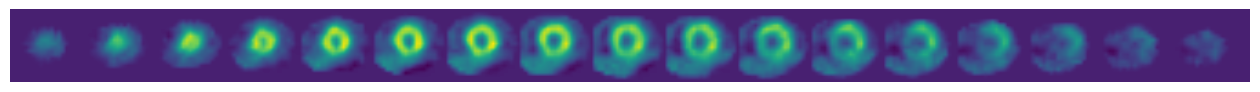

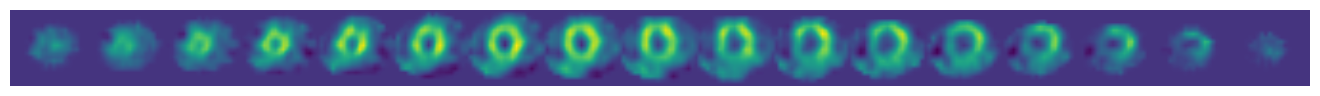

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

import copy
import math
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from scipy.ndimage import label, center_of_mass
from skimage.measure import regionprops
from scipy.ndimage import zoom
from scipy.optimize import minimize
from sklearn.linear_model import RANSACRegressor



DATA_COLLECTION = "/mnt/labnas/DataCollection"
base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "healthy")
demo_dir = os.path.join(base_dir, "000652515")


def read_sitk_img(path):
    sitk_img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(sitk_img)
    # SimpleITK: image[x,y,z]; numpy: image_numpy_array[z,y,x]
    print(f"img meta: \n shape:{img_arr.shape} \n spacing:{sitk_img.GetSpacing()[::-1]}")
    return img_arr


non_gate_img3d = read_sitk_img(os.path.join(demo_dir, "154"))
gate_img4d = read_sitk_img(os.path.join(demo_dir, "155"))
view_results3d = read_sitk_img(os.path.join(demo_dir, "161"))



plt.figure(figsize=(16, 5))
plt.imshow(view_results3d[0], interpolation="bilinear")
plt.axis('off')
plt.show()


width = 20
# 计算中心位置
center = np.array(non_gate_img3d.shape)//2
start = center - width//2
end = center + width//2

clipped_non_gate_img3d = non_gate_img3d[:, start[1]:end[1], start[2]:end[2]].copy()
plt.figure(figsize=(16, 5))
plt.imshow(clipped_non_gate_img3d.transpose(1, 0, 2).reshape(width, -1), interpolation="bilinear")
plt.axis('off')
plt.show()


clipped_gate_img4d = gate_img4d[:, start[1]:end[1], start[2]:end[2]].copy()
unit = clipped_gate_img4d.shape[0] // 8

plt.rcParams["animation.html"] = "jshtml"
fig = plt.figure(figsize=(13, 1))
plt.ioff()
def animate(t):
    plt.cla()
    # plt.plot(x-t,x)
    frame_i = clipped_gate_img4d[t*unit: (t+1)*unit]
    plt.imshow(frame_i.transpose(1, 0, 2).reshape(width, -1), interpolation="bilinear")
    plt.axis('off')  # Hide axes and ticks completely
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding

# Create animation
FuncAnimation(fig, animate, frames=8)

In [1]:
import numpy as np
from scipy.optimize import minimize

def weighted_smooth(data, weights, smoothness=0.1, max_diff=5):
    """
    加权最小二乘法平滑，并限制相邻数据点差值不超过 max_diff
    :param data: 原始数据（列表或 numpy 数组）
    :param weights: 权重数组（列表或 numpy 数组）
    :param smoothness: 平滑系数（越大越平滑）
    :param max_diff: 相邻数据点最大允许差值
    :return: 平滑后的数据（numpy 数组）
    """
    # 将输入转换为 numpy 数组
    data = np.array(data, dtype=np.float32)
    weights = np.array(weights, dtype=np.float32)

    # 检查输入数据
    assert len(data) == len(weights), "data 和 weights 的长度必须一致"
    assert len(data) > 1, "数据长度必须大于 1"

    def objective(x):
        """
        目标函数：加权误差 + 平滑惩罚
        """
        # 加权误差
        weighted_error = np.sum(weights * (x - data) ** 2)
        # 平滑惩罚（相邻点差值的平方和）
        smooth_penalty = np.sum((x[1:] - x[:-1]) ** 2)
        return weighted_error + smoothness * smooth_penalty

    def constraint(x):
        """
        约束条件：相邻数据点差值不超过 max_diff
        """
        return max_diff - np.abs(x[1:] - x[:-1])

    # 初始猜测为原始数据
    x0 = data.copy()

    # 约束条件
    cons = {'type': 'ineq', 'fun': constraint}  # 不等式约束

    # 最小化目标函数
    try:
        result = minimize(objective, x0, method='SLSQP', constraints=cons)
        if result.success:
            return np.round(result.x).astype(np.uint8)  # 返回平滑后的数据（四舍五入为整数）
        else:
            raise RuntimeError(f"优化失败: {result.message}")
    except Exception as e:
        print(f"优化过程中发生错误: {e}")
        return data  # 返回原始数据作为 fallback


# 示例用法
if __name__ == "__main__":
    # 示例数据
    data = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            0, 5, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2,
            2, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
    weights = [1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06,
               1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06,
               1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 4.0e+00, 2.0e+01,
               2.0e+01, 3.2e+01, 3.2e+01, 3.2e+01, 3.4e+01, 3.4e+01, 3.4e+01, 3.4e+01, 3.4e+01,
               3.5e+01, 3.5e+01, 3.5e+01, 3.5e+01, 3.5e+01, 3.5e+01, 4.0e+01, 4.0e+01, 4.0e+01,
               3.8e+01, 3.8e+01, 3.8e+01, 2.4e+01, 1.7e+01, 1.7e+01, 1.7e+01, 3.0e+00, 3.0e+00,
               3.0e+00, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06, 1.0e-06]

    # 调用平滑函数
    smoothed_data = weighted_smooth(data, weights, smoothness=0.5, max_diff=5)
    print("原始数据:", data)
    print("平滑后的数据:", smoothed_data)

优化过程中发生错误: failed to initialize intent(inout) array -- expected elsize=8 but got 4
原始数据: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0]
平滑后的数据: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 5. 2. 2. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 2. 2. 2.
 2. 3. 3. 3. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
def cal_lv_mask3d(img3d, meta, preframe_info=None, debug=False):
    pass